# Aufagbe 4 - Behavioural Cloning

In [69]:
#Importieren der benötigten Bibliotheken und des Datensatzes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import KFold nicht genutzt da keras die funktion von KFold bereits integriert hat

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam

df = pd.read_csv('dataset.csv')


### 4.1 Keras Seed 42 setzen
Den Seed von Keras auf 42 zu setzen, stellt sicher, dass die Initialisierung der Gewichte und andere zufällige Prozesse in Keras reproduzierbar sind (Dazu gehören auch die Seeds für  Python und Tf random Modul). Dadurch können konsistente Ergebnisse erzielt werden, wenn wir das Modell mehrmals trainieren oder verschiedene Modelle vergleichen.

In [70]:
#Keras Seed auf 42 setzen
keras.utils.set_random_seed(42)

In [71]:
#Labes richtig setzten
X = df[['current_absolute_pose_x', 'current_absolute_pose_y', 'current_absolute_pose_z', 'current_absolute_pose_qx', 'current_absolute_pose_qy', 'current_absolute_pose_qz', 'current_absolute_pose_qw','ft_wrench_fx', 'ft_wrench_fy', 'ft_wrench_fz', 'ft_wrench_tx', 'ft_wrench_ty', 'ft_wrench_tz','current_twist_vx', 'current_twist_vy', 'current_twist_vz', 'current_twist_wx', 'current_twist_wy', 'current_twist_wz']]
Y = df[['action_f_x', 'action_f_y', 'action_f_z', 'action_t_x', 'action_t_y', 'action_t_z']]

#Trainings- und Testdaten aufteilen
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [72]:
#Skalieren der Daten

#MinMaxScaler für die Eingabedaten und die Zielwerte erstellen, einmal für X und einmal für Y, damit sie unabhängig voneinander skaliert werden können
scalar_x = MinMaxScaler()
scalar_y = MinMaxScaler()

#Skalieren der Trainings- und Testdaten
X_train_scaled = scalar_x.fit_transform(X_train)
X_test_scaled = scalar_x.transform(X_test)

Y_train_scaled = scalar_y.fit_transform(Y_train)
Y_test_scaled = scalar_y.transform(Y_test)

print(f"Bereich von X_train_scaled: [{np.min(X_train_scaled):.1f} : {np.max(X_train_scaled):.1f}]")
print(f"Bereich von X_test_scaled: [{np.min(X_test_scaled):.4f} : {np.max(X_test_scaled):.4f}]")
print(f"Bereich von Y_train_scaled: [{np.min(Y_train_scaled):.1f} : {np.max(Y_train_scaled):.1f}]")
print(f"Bereich von Y_test_scaled: [{np.min(Y_test_scaled):.4f} : {np.max(Y_test_scaled):.4f}]")

Bereich von X_train_scaled: [0.0 : 1.0]
Bereich von X_test_scaled: [-0.0119 : 1.0087]
Bereich von Y_train_scaled: [0.0 : 1.0]
Bereich von Y_test_scaled: [-0.0152 : 0.9998]


### 4.4 Skaliere die Daten
Das Skalieren der Daten ist notwendig, um sicherzustellen, dass alle Features auf einem ähnlichen Wertebereich liegen. Wenn das nicht gemacht wird, werden Werte wie 50N das Training dominieren und kleine Werte wie die Positionsdaten werden nicht beachtet. Es kann ebenfalls die Konvergenz des Modells verbessern und die Trainingszeit verkürzen.

Ein ML-Verfahren bei dem keine Skalierung benötigt wird, ist z.B. Random Forest, da er auf Entscheidungsbäumen basiert, die nicht von der Skala der Daten beeinflusst werden.

In [73]:
#Trainieren, MSE berechnen 

#Modell erstellen
model = Sequential()
model.add(Input(shape=(19,))) #Input Layer mit 19 Features, wir haben 19 Sensorwerte als Eingabe
model.add(Dense(64, activation='relu')) #Hidden Layer mit 64 Neuronen und Relu-Aktivierungsfunktion
model.add(Dropout(0.2)) #Dropout Layer mit 20% Wahrscheinlichkeit
model.add(Dense(6, activation='linear')) #Output Layer mit 6 Aktionen
model.compile(optimizer=Adam(), loss='mse') #Modell mit Adam Optimizer und Mean Squared Error Loss Funktion kompilieren


#Modell trainieren
#Epochs auf 10 gesetzt, da der Verlust bereits nach wenigen Epochen unter 0.01 liegt.
#Krossvalidierung wird hier mit der Funktion von Keras, mit einem Validation Split von 0.2, durchgeführt.
history = model.fit(X_train_scaled,
                    Y_train_scaled,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2
                    )

#MSE berechnen
test_loss = model.evaluate(X_test_scaled, Y_test_scaled)
print(f'MSE: {test_loss:.4f}')


Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0941 - val_loss: 0.0121
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.0185 - val_loss: 0.0080
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0132 - val_loss: 0.0075
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - val_loss: 0.0068
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.0106 - val_loss: 0.0065
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 0.0096 - val_loss: 0.0066
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.0093 - val_loss: 0.0062
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.0086 - val_loss: 0.0059
Epoch 9/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.0083 - val_loss: 0.0059
Epoch 10/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.0079 - val_loss: 0.0058
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.0056
MSE: 0.0056


### 4.6 Bedeutung von Regularisierung
Regularisierung ist eine Technik die Overfiiting verhindert, komplexe Modelle werden bestraft um sie nicht auswendig lernen zu lassen. Sie trägt zur Verbesserung der Generalisierungsfähigkeit eines Modells bei, indem sie dessen Komplexität begrenzt und es zwingt, einfachere Lösungen zu finden. In unserem Fall könnte Regularisierung verhindern, dass sich das Modell zu stark an die Trainingsdaten anpasst und somit seine Leistung bei neuen Daten verbessert.

Das von mir verwendete Dropout ist eine Form der Regularisierung, bei der während des Trainings zufällig ausgewählte Neuronen deaktiviert werden. Dies zwingt das Modell, robuste Merkmale zu lernen, die nicht von einzelnen Neuronen abhängen, und verbessert so die Generalisierungsfähigkeit des Modells.

Text(0, 0.5, 'Loss')

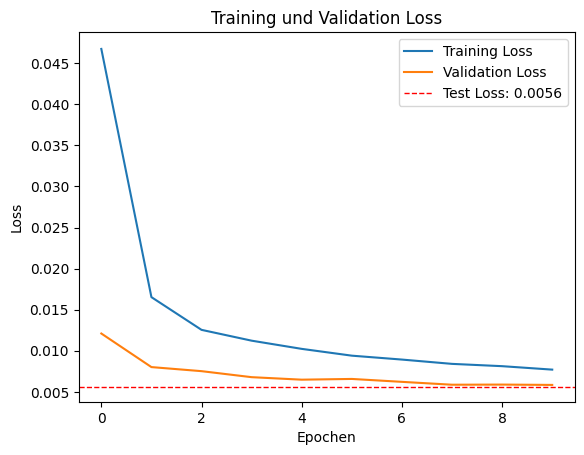

In [74]:
#Plotten des Loss über Epochen

#Plotten von Loss und Val_Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

#Test Loss als horizontale Linie hinzufügen
plt.axhline(y=test_loss, color='red', linestyle='--', linewidth=1, label=f'Test Loss: {test_loss:.4f}')

plt.title('Training und Validation Loss')
plt.legend()
plt.xlabel('Epochen')
plt.ylabel('Loss')

### 4.7 Erklärung des Plots
Der Plot zeigt die Entwicklung des Trainings- und Validierungsverlusts über die 10 Epochen. Beide Kurven fallen sehr schnell ab, bereits nach 5 Epochen liegt der Verlust unter dem geforderten Schwellenwert von 0.01. Training Loss und Validation Loss verlaufen nahe beieinander, was zeigt dass das Modell nicht overfittet und gut generalisiert. Dass der Training Loss dabei leicht über dem Validation Loss liegt, ist auf den aktiven Rate von 20% Dropout während des Trainings zurückzuführen. Bei der Validierung wird dieser automatisch deaktiviert, wodurch das Modell seine volle Kapazität nutzen kann und der Fehler sinkt.

Das schnelle Abfallen des Verluste lässt sich dadurch erklären, dass die Demonstrationen sehr konsistent aufgezeichnet wurden. Das Mapping von Sensorwerten zu Aktionen ist daher für das Netz einfach zu erlernen.

Der Test Loss liegt nahe an den finalen Werten der beiden Kurven, was die gute Generalisierungsfähigkeit des Modells auf ungesehenen Daten bestätigt.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


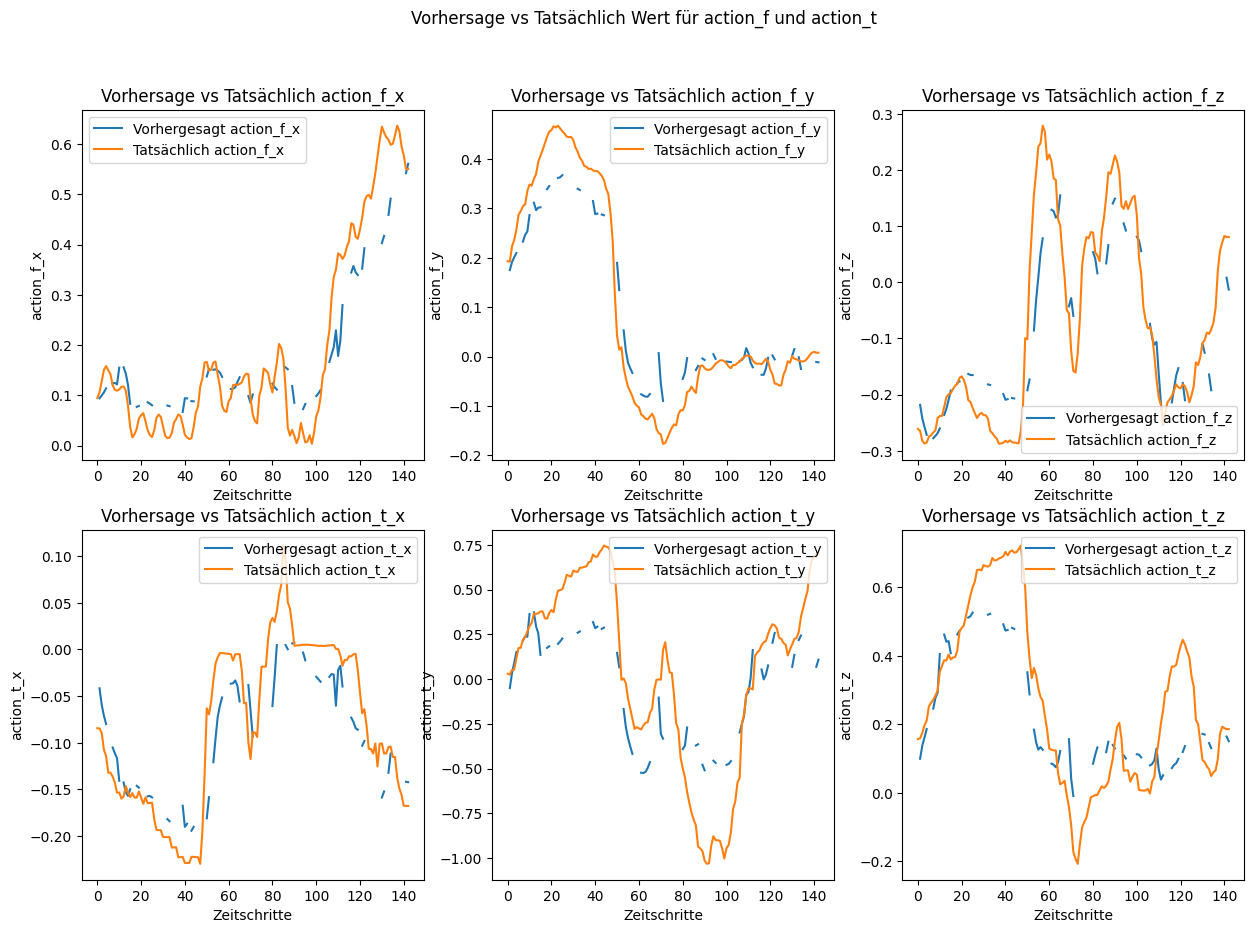

In [75]:
#Laden einer seperaten Episode
df_nofiltered = pd.read_csv('data_v2/data_train_set/episode_100.csv', sep=';', decimal=',')

#Labes richtig setzten wie oben
X_nofiltered = df_nofiltered[['current_absolute_pose_x', 'current_absolute_pose_y', 'current_absolute_pose_z', 'current_absolute_pose_qx', 'current_absolute_pose_qy', 'current_absolute_pose_qz', 'current_absolute_pose_qw','ft_wrench_fx', 'ft_wrench_fy', 'ft_wrench_fz', 'ft_wrench_tx', 'ft_wrench_ty', 'ft_wrench_tz','current_twist_vx', 'current_twist_vy', 'current_twist_vz', 'current_twist_wx', 'current_twist_wy', 'current_twist_wz']]
Y_nofiltered = df_nofiltered[['action_f_x', 'action_f_y', 'action_f_z', 'action_t_x', 'action_t_y', 'action_t_z']]

#Skalieren der Daten
X_nofiltered_scaled = scalar_x.transform(X_nofiltered)

#Vorhersagen mit dem trainierten Modell
Y_nofiltered_pred = model.predict(X_nofiltered_scaled)
Y_nofiltered_original = scalar_y.inverse_transform(Y_nofiltered_pred)

#Plotten der Vorhersagen vs. den tatsächlichen Werten für action_f und action_t
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.suptitle('Vorhersage vs Tatsächlich Wert für action_f und action_t')
for i, col in enumerate(Y_nofiltered.columns):
    row = i // 3 # Bestimmt die Zeile (0 oder 1) basierend auf dem Index
    col_idx = i % 3 # Bestimmt die Spalte (0, 1 oder 2) basierend auf dem Index
    axes[row, col_idx].plot(Y_nofiltered_original[:, i], label=f'Vorhergesagt {col}')
    axes[row, col_idx].plot(Y_nofiltered[col], label=f'Tatsächlich {col}')
    axes[row, col_idx].set_title(f'Vorhersage vs Tatsächlich {col}')
    axes[row, col_idx].legend()
    axes[row, col_idx].set_xlabel('Zeitschritte')
    axes[row, col_idx].set_ylabel(col)
plt.show()


### 4.8 Interpretation der Ergebnisse
Die Vorhersagen folgen im großen Teil den Aktionen des Demonstrators. Es gibt einige Abweichungen, vor allem in action_t_y und action_t_z. Die blaue Linie wird auch nur in Abschnitten dargestellt, da die Episode fehlende Werte hat, die nicht aufgefüllt wurden. Das Modell hat aber die grundlegende Bewegungsstrategie gelernt.

### 4.9 Welche Probleme könnten auftreten, wenn das Modell in einer realen Umgebung eingesetzt wird?

- Das Modell kann in Situationen geraten, die nicht im Trainingsdatensatz vorkamen, z.B. eine neue Startposition oder Umgebung. Das Modell kann zwar in gewissem Maß generalisieren, ist aber nicht in der Lage vollständig neue Situationen zu bewältigen und würde weiteres Training benötigen.

- Aufzeichnung und reales System stimmen nie zu 100% überein. Messabweichungen der Sensoren, unterschiedliche Motoren oder Toleranzen sowie andere Umwelteinflüsse wie Reibung führen dazu, dass die gelernten Aktionen nicht direkt auf den echten Roboter übertragbar sind.

- Fehler könne sich akkumulieren. Wenn das Modell einmal eine leicht falsche Aktion wählt, kommt es in einen Zustand den es im Training nie gesehen hat und macht dort wieder einen Fehler. Diese Fehler summieren sich auf, bis der Roboter komplett die Kontrolle verliert.

### 4.10 Vorschläge zur Verbesserung der Datenaufzeichnung

- Mehr Demonstrationen aufzeichnen, um eine größere Vielfalt an Situationen und Bewegungen abzudecken. Das könnte dem Modell helfen, besser zu generalisieren und auch in neuen Situationen angemessen zu reagieren

- Datenaugmentation verwenden, z.B. durch Hinzufügen von Rauschen zu den Sensorwerten oder durch Spiegeln der Bewegungen, um die Robustheit des Modells zu erhöhen.

- Fehlende Werte in den Demonstrationen auffüllen, z.B. durch Interpolation oder durch Verwendung von Modellen, die mit unvollständigen Daten umgehen können. Dadurch könnte das Modell auch in Situationen besser performen, in denen nicht alle Sensorwerte verfügbar sind.